In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step


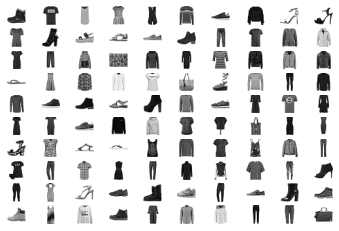

In [ ]:
from keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [ ]:
trainX.shape

(60000, 28, 28)

In [ ]:
testX.shape

(10000, 28, 28)

In [ ]:
trainy.shape

(60000,)

In [ ]:
discriminator = Sequential()
	# downsample
discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=(28,28,1)))
discriminator.add(LeakyReLU(alpha=0.2))
# downsample
discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
# classifier
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid'))
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
generator = Sequential()
	# foundation for 7x7 image
n_nodes = 128 * 7 * 7
generator.add(Dense(n_nodes, input_shape=(100,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((7, 7, 128)))
# upsample to 14x14
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
# upsample to 28x28
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
# generate
generator.add(Conv2D(1, (7,7), activation='tanh', padding='same'))

In [ ]:
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 128)      

In [ ]:
discriminator.trainable = False
	# connect them
gan = Sequential()
# add generator
gan.add(generator)
# add the discriminator
gan.add(discriminator)
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
gan.compile(loss='binary_crossentropy', optimizer=opt)

In [ ]:
gan.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 155137    
Total params: 1,319,426
Trainable params: 1,164,289
Non-trainable params: 155,137
_________________________________________________________________


In [ ]:
for i in range(2):
		# enumerate batches over the training set
  for j in range(60000//32):
    # get randomly selected 'real' samples


    ix = randint(0, trainX.shape[0], 32)
    # select images
    X_real = trainX[ix]
    X_real = expand_dims(X_real, axis=-1)
    # convert from ints to floats
    X_real = X_real.astype('float32')
    # scale from [0,255] to [-1,1]
    X_real = (X_real - 127.5) / 127.5
    # generate class labels
    y_real = ones((32, 1))

    # update discriminator model weights
    d_loss1, _ = discriminator.train_on_batch(X_real, y_real)
    # generate 'fake' examples


    # generate points in latent space as input for the generator
    x_input = randn(100 * 32)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(32, 100)

    X_fake = generator.predict(x_input)
    # create class labels
    y_fake = zeros((32, 1))

    # update discriminator model weights
    d_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)
    # prepare points in latent space as input for the generator
    discriminator.trainable = False

    x_gan = randn(100 * 64)
    # reshape into a batch of inputs for the network
    x_gan = x_gan.reshape(64, 100)

    # create inverted labels for the fake samples
    y_gan = ones((64, 1))
    # update the generator via the discriminator's error
    g_loss = gan.train_on_batch(x_gan, y_gan)
    # summarize loss on this batch
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
      (i+1, j+1, 60000//32, d_loss1, d_loss2, g_loss))
	# save the generator model
generator.save('generator.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/1875, d1=0.660, d2=0.715 g=0.722
>1, 2/1875, d1=0.642, d2=0.698 g=0.765
>1, 3/1875, d1=0.759, d2=0.702 g=0.761
>1, 4/1875, d1=0.598, d2=0.679 g=0.799
>1, 5/1875, d1=0.750, d2=0.662 g=0.792
>1, 6/1875, d1=0.672, d2=0.649 g=0.756
>1, 7/1875, d1=0.675, d2=0.689 g=0.770
>1, 8/1875, d1=0.682, d2=0.699 g=0.735
>1, 9/1875, d1=0.680, d2=0.659 g=0.763
>1, 10/1875, d1=0.719, d2=0.704 g=0.741
>1, 11/1875, d1=0.754, d2=0.647 g=0.747
>1, 12/1875, d1=0.724, d2=0.701 g=0.762
>1, 13/1875, d1=0.648, d2=0.686 g=0.716
>1, 14/1875, d1=0.688, d2=0.691 g=0.753
>1, 15/1875, d1=0.659, d2=0.679 g=0.708
>1, 16/1875, d1=0.734, d2=0.683 g=0.754
>1, 17/1875, d1=0.661, d2=0.657 g=0.716
>1, 18/1875, d1=0.625, d2=0.724 g=0.706
>1, 19/1875, d1=0.636, d2=0.694 g=0.772
>1, 20/1875, d1=0.721, d2=0.720 g=0.722
>1, 21/1875, d1=0.668, d2=0.754 g=0.721
>1, 22/1875, d1=0.701, d2=0.730 g=0.761
>1, 23/1875, d1=0.673, d2=0.678 g=0.723
>1, 24/1875, d1=0.687, d2=0.665 g=0.720
>1, 25/1875, d1=0.655, d2=0.677 g=0.775
>1, 26/18

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


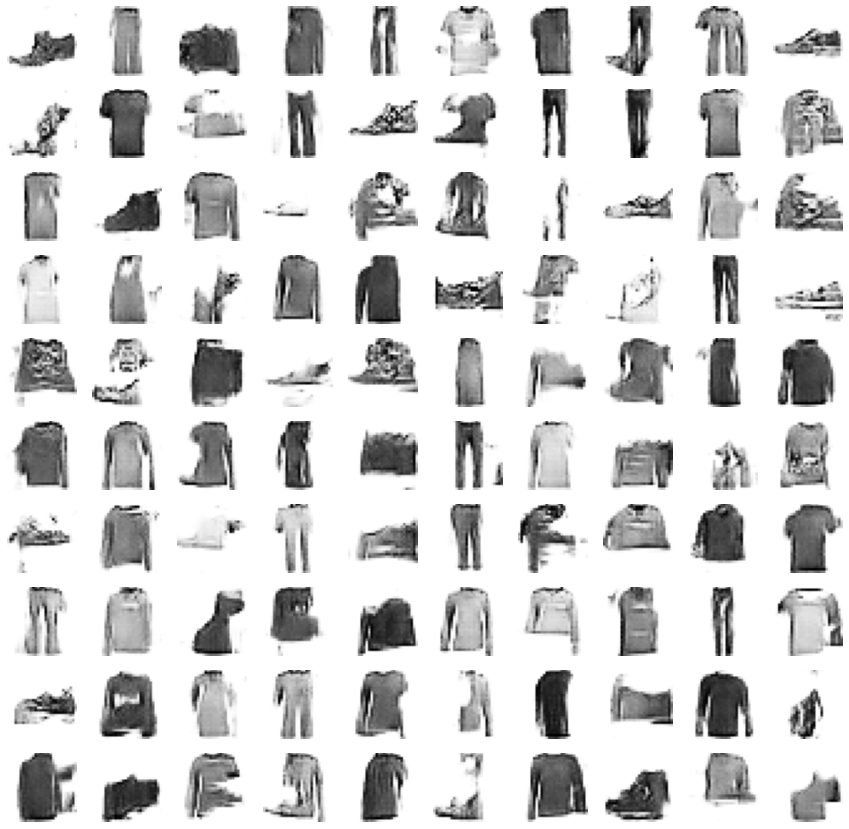

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

model = load_model('generator.h5')

# generate points in the latent space
x_input = randn(100 * 100)
# reshape into a batch of inputs for the network
x_input = x_input.reshape(100, 100)


X = model.predict(x_input)

pyplot.figure(figsize=(15,15))
for i in range(100):
		# define subplot
  pyplot.subplot(10, 10, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
pyplot.show()